<a href="https://colab.research.google.com/github/Nush395/pruning/blob/master/network_pruning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Training a large network on MNIST and then pruning it to make it smaller using weight and unit pruning.

# Requirements and Imports

In [ ]:
!pip install tensorflow==2.2.0

# Data and model set up

In [16]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, ReLU, Dense, Flatten
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

## Define a Pruned Model

Here I've defined a custom model which contains methods to prune units and neurons. A mask is applied to weights with value zero (I've assumed a weight will only be zero if it's pruned) so that they won't be updated by backprop anymore.

In [17]:
class PruneLayer(Dense):
    def __init__(self, units):
        super().__init__(units, use_bias=False, activation='relu')
        self.sparse_kernel = None
        self.sparse_compute = False

    def build(self, input_shape):
        super().build(input_shape)
        self.mask = tf.ones_like(self.kernel, dtype=tf.float32)

    def create_sparse_kernel(self):
        if self.built:
            self.sparse_kernel = tf.sparse.from_dense(self.kernel)
            self.sparse_compute = True
        else:
            raise Exception("There isn't yet a kernel to make sparse.")

    def reset_sparse_kernel(self):
        self.sparse_kernel = None
        self.sparse_compute = False

    def call(self, inputs, training=None):
        if self.sparse_compute and not training:
            x = tf.sparse.sparse_dense_matmul(inputs, self.sparse_kernel)
        else:
            x = tf.linalg.matmul(inputs, self.mask * self.kernel)

        return self.activation(x) 

In [18]:
class PruneModel(tf.keras.Model):
    def __init__(self, sparse_compute=False):
        super().__init__()
        hidden_layer_units = [1000, 1000, 500, 200]
        self.hidden_layers = [PruneLayer(units) for units in hidden_layer_units]
        self.prunable_layers = self.hidden_layers
        self.output_layer = Dense(10, activation='softmax', use_bias=False)

    def call(self, inputs):
        x = Flatten()(inputs)
        for layer in self.hidden_layers:
            x = layer(x)

        return self.output_layer(x)

    def prune(self, sparsity: float, mode='weight'):
        """Apply pruning of specified mode to all the layers that have been
        defined as prunable_layers.

        Args:
            sparsity: The percentage of sparsity to be achieved.
            mode: The pruning criterion to use.
        """
        if not self.built:
            raise ValueError("Model must be built.")
        if not 0 <= sparsity < 100:
            raise ValueError("Sparsity must be in [0,100].")

        for layer in self.prunable_layers:
            weights = layer.get_weights()[0]
            if mode == 'weight':
                pruned_weights = self._prune_matrix_weights(weights, sparsity)
            elif mode == 'unit':
                pruned_weights = self._prune_matrix_units(weights, sparsity)
            else:
                raise ValueError("Unrecognised mode of pruning.")

            layer.set_weights([pruned_weights])
            layer.mask = tf.cast(tf.not_equal(layer.kernel,0), 'float32')

    @staticmethod
    def _prune_matrix_weights(weights: np.ndarray, sparsity: float):
        """Prune a percentage of the weights in a layer that have the smallest
        magnitude.
        
        Args:
            weights: The input weight matrix to be pruned.
            sparsity: The percantage of weights to prune.
        Returns:
            pruned_weights: The pruned weight matrix.
        """
        pruned_weights = weights.flatten()
        num_to_prune = int(len(pruned_weights) * (sparsity / 100))
        smallest_indices = np.argpartition(np.absolute(pruned_weights), 
                                           num_to_prune)[:num_to_prune]
        pruned_weights[smallest_indices] = 0
        pruned_weights = pruned_weights.reshape(weights.shape)

        return pruned_weights

    @staticmethod
    def _prune_matrix_units(weights: np.ndarray, sparsity: float):
        """Prune a percentage of the columns of the input matrix that have the
        smallest L2 norm.

        Args:
            weights: The input weight matrix to be pruned.
            sparsity: The percentage of columns to prune.
        Returns:
            weights: The pruned weight matrix.
        """
        num_to_prune = int(weights.shape[1] * (sparsity / 100))
        norms = np.linalg.norm(weights, axis=0)
        smallest_indices = np.argpartition(norms, num_to_prune)[:num_to_prune]
        weights[:, smallest_indices] = 0

        return weights

    def create_sparse_kernels(self):
        for layer in self.prunable_layers:
            layer.create_sparse_kernel()

    def reset_sparse_kernels(self):
        for layer in self.prunable_layers:
            layer.reset_sparse_kernel()

## Data, model preparation and training.

---



Preparation of MNIST data, fitting and then evaluating the unpruned model.

In [19]:
# create a model
model = PruneModel()
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=0, 
                                      patience=5)

In [20]:
# load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255
y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

In [ ]:
# fit the model
history = model.fit(x_train, y_train, batch_size=512, epochs=100, 
                    validation_split=0.2, callbacks=[es])

In [22]:
# Evaluate the model on the unseen test data.
test_scores = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', test_scores[0])
print('Test accuracy:', test_scores[1])

Test loss: 0.11382591724395752
Test accuracy: 0.9732999801635742


# Pruning Evaluation

## Before fine-tuning

In [23]:
unpruned_weights = model.get_weights()
pruning_factors = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

In [24]:
w_pruning_acc = []
for pf in pruning_factors:
    model.prune(pf, mode='weight')
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    w_pruning_acc.append(test_scores[1])

In [25]:
u_pruning_acc = []
model.set_weights(unpruned_weights)
for pf in pruning_factors:
    model.prune(pf, mode='unit')
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    u_pruning_acc.append(test_scores[1])

Text(0, 0.5, 'Accuracy')

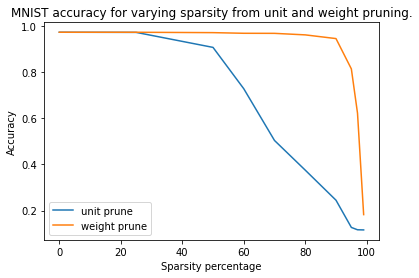

In [26]:
df = pd.DataFrame(index=pruning_factors, data={'unit prune': u_pruning_acc,
                                               'weight prune': w_pruning_acc})
ax = df.plot.line(title='MNIST accuracy for varying sparsity from unit and weight pruning.')
ax.set_xlabel("Sparsity percentage")
ax.set_ylabel("Accuracy")

## After fine-tuning

As mentioned in [this post](https://jacobgil.github.io/deeplearning/pruning-deep-learning) significant pruning can damage the network so much it can't recover so in practice we want to iteratively prune, retrain and repeat. In this section I fine tune the pruned networks to see if they can learn something using the new structure. 

Note: There are 10 models fine tuned for each pruning method here for as many epochs as they take to overfit the training set. This takes a bit longer so you can reduce the max_epochs variable defined below to make this faster.

In [27]:
max_epochs = 100

In [28]:
# fine tuning after weight pruning
model.set_weights(unpruned_weights)
w_pruning_acc = []
for pf in pruning_factors:
    model.prune(pf, mode='weight')
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=512, epochs=max_epochs, 
              validation_split=0.2, callbacks=[es], verbose=0)
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    w_pruning_acc.append(test_scores[1])

In [29]:
# fine tuning after unit pruning
model.set_weights(unpruned_weights)
u_pruning_acc = []
for pf in pruning_factors:
    model.prune(pf, mode='unit')
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    model.fit(x_train, y_train, batch_size=512, epochs=max_epochs, 
              validation_split=0.2, callbacks=[es], verbose=0)
    test_scores = model.evaluate(x_test, y_test, verbose=0)
    u_pruning_acc.append(test_scores[1]) 

Text(0, 0.5, 'Accuracy')

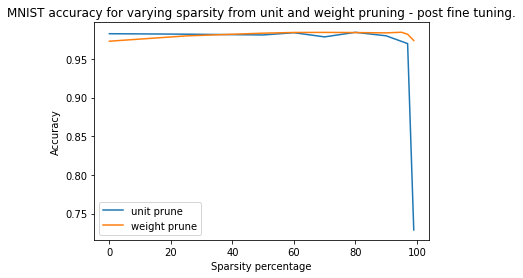

In [30]:
df = pd.DataFrame(index=pruning_factors, data={'unit prune': u_pruning_acc,
                                               'weight prune': w_pruning_acc})
ax = df.plot.line(title=('MNIST accuracy for varying sparsity from unit and weight pruning - post fine tuning.'))
ax.set_xlabel("Sparsity percentage")
ax.set_ylabel("Accuracy")

Fine tuning has definitely improved the pruned model performance!

# Bonus - Improving inference time for sparse model

In the TF Docs I found that the tf.sparse module has a sparse_dense_matmul method for taking advantage of one matrix being sparse. As the sparse weight pruned models still perform well, going to have a play and see if we can speed up inference time exploiting these optimisations.

In [31]:
normal_infer = []
sparse_infer = []

for pf in pruning_factors:
    # normal inference
    model.set_weights(unpruned_weights)
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    start_time = time.time()
    predict1 = model.predict(x_test, verbose=0)  
    normal_infer.append(time.time()-start_time)

    # inference with sparse optimisation
    model.prune(pf)
    model.create_sparse_kernels()
    
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])
    start_time = time.time()
    predict2 = model.predict(x_test, verbose=0)
    sparse_infer.append(time.time()-start_time)

    # reset the sparse kernel for the next iteration
    model.reset_sparse_kernels()

Text(0, 0.5, 'Time for inference/s')

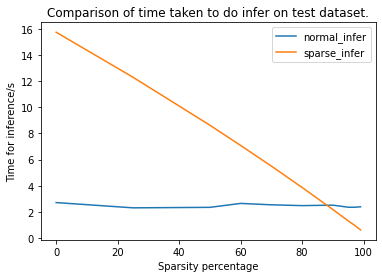

In [32]:
df = pd.DataFrame(index=pruning_factors, data={'normal_infer': normal_infer,
                                               'sparse_infer': sparse_infer})
ax = df.plot.line(title="Comparison of time taken to do infer on test dataset.")
ax.set_xlabel('Sparsity percentage')
ax.set_ylabel('Time for inference/s')

So taking advantage of sparse computations in this case does yield faster inference but only if the sparsity is above a certain threshold.

# Conclusions

We observe in both curves for unit and weight pruning cases that networks can be pruned up to 80% sparsity without significant drop in performance. In fact after fine-tuning the accuracy of some of the networks pruned using weight pruning increases. The curves before and after fine tuning show that fine tuning is important in this task for restoring the model's performance, as mentioned in [this post](https://jacobgil.github.io/deeplearning/pruning-deep-learning) the network can be damaged if we prune too much and so fine-tuning helps the performance recover.

In terms of explaining why we can delete so much of the original network and maintan accuracy, previous work on pruning [1] demonstrates that the function learned by a neural network can often be represented with much fewer parameters so we can delete a large amount of the network without hurting performance provided we keep the important parameters. An interesting hypothesis mentioned in [2] is that the structure uncovered by the sparse networks encode an inductive bias customized to the learning task at hand, in this case image recognition for digits. Following this hypothesis we could say that the original network encodes lots of different structure configurations, allowing us to learn the optimal structure. Then once we learn the optimal one we can strip away the rest of the network without harming the performance.

The pruning vs accuracy curves also show that weight pruning is more robust than unit pruning. I found this to be a pretty interesting result and could be explained by the fact that the representational capacity of the weight pruned network remains higher than that of the unit pruned network as we can project the data into a higher-dimensional embedding if there are more neurons.

We also found that in this task taking advantage of Tensorflow sparse matrix multiplication helps to get faster inference time but only if the network is sparse enough. As this network is quite small compared to some modern deep neural networks the effect of taking advantage of sparse computations would be even greater in a larger network.


# References

[1] Song Han, Jeff Pool, John Tran, and William Dally. Learning both weights and connections for
efficient neural network. In Advances in neural information processing systems, pp. 1135–1143,
2015

[2] J. Frankle and M. Carbin. The lottery ticket hypothesis: Finding sparse, trainable neural networks. In
International Conference on Learning Representations (ICLR), 2019.